In [ ]:
%pip install tensorflow
%pip install scikit-learn
%pip install keras-tuner
%pip install seaborn

In [2]:
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image

from keras_tuner.tuners import RandomSearch

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Setup

In [2]:
#Defining dataset path
original_folder = Path("Plant_Diseases")  
for folder in original_folder.iterdir():
    if folder.is_dir():
        print("Found folder:", folder.name)


Found folder: chili
Found folder: bean
Found folder: tomato


In [3]:
#Going through every folder in the dataset
def load_metadata(folder: Path):
    valid_exts = {".jpg", ".jpeg", ".png"}
    data = []
    for plant_folder in folder.iterdir():
        if plant_folder.is_dir():
            plant = plant_folder.name.lower().strip()

            for condition_folder in plant_folder.iterdir():
                if condition_folder.is_dir():
                    condition = condition_folder.name.lower().strip()

                    for img_file in condition_folder.glob("*"):
                        path_lower = Path(str(img_file).lower())
                        ext = path_lower.suffix
                        if ext in valid_exts:
                            try:
                                img_path = img_file.resolve()
                                data.append({
                                    "image_path": str(img_path),  # convert Path → string
                                    "plant": plant,
                                    "condition": condition,
                                    "combined_label": f"{plant}_{condition}"
                                })
                            except Exception as e:
                                print(f"⚠️ Skipping {img_file.name}: {e}")
    return pd.DataFrame(data)
                            



In [4]:
#Loading dataset
df_original = load_metadata(original_folder)
print(df_original.head())
print(f"\nTotal images loaded: {len(df_original)}")

                                          image_path  plant  \
0  /work/Exam ML 2025/Plant_Diseases/chili/bacter...  chili   
1  /work/Exam ML 2025/Plant_Diseases/chili/bacter...  chili   
2  /work/Exam ML 2025/Plant_Diseases/chili/bacter...  chili   
3  /work/Exam ML 2025/Plant_Diseases/chili/bacter...  chili   
4  /work/Exam ML 2025/Plant_Diseases/chili/bacter...  chili   

             condition             combined_label  
0  bacterial leaf spot  chili_bacterial leaf spot  
1  bacterial leaf spot  chili_bacterial leaf spot  
2  bacterial leaf spot  chili_bacterial leaf spot  
3  bacterial leaf spot  chili_bacterial leaf spot  
4  bacterial leaf spot  chili_bacterial leaf spot  

Total images loaded: 10955


In [5]:
# Get all  class folders
# Collect combined class names as "plant___condition"
class_names = sorted({
    f"{plant_folder.name}_{subfolder.name}"
    for plant_folder in original_folder.iterdir() if plant_folder.is_dir()
    for subfolder in plant_folder.iterdir() if subfolder.is_dir()
})

print(f"Total number of combined classes: {len(class_names)}")
print("Example combined classes:", class_names[:5])

Total number of combined classes: 14
Example combined classes: ['bean_anthracnose', 'bean_healthy', 'bean_rust', 'chili_bacterial leaf spot', 'chili_healthy']


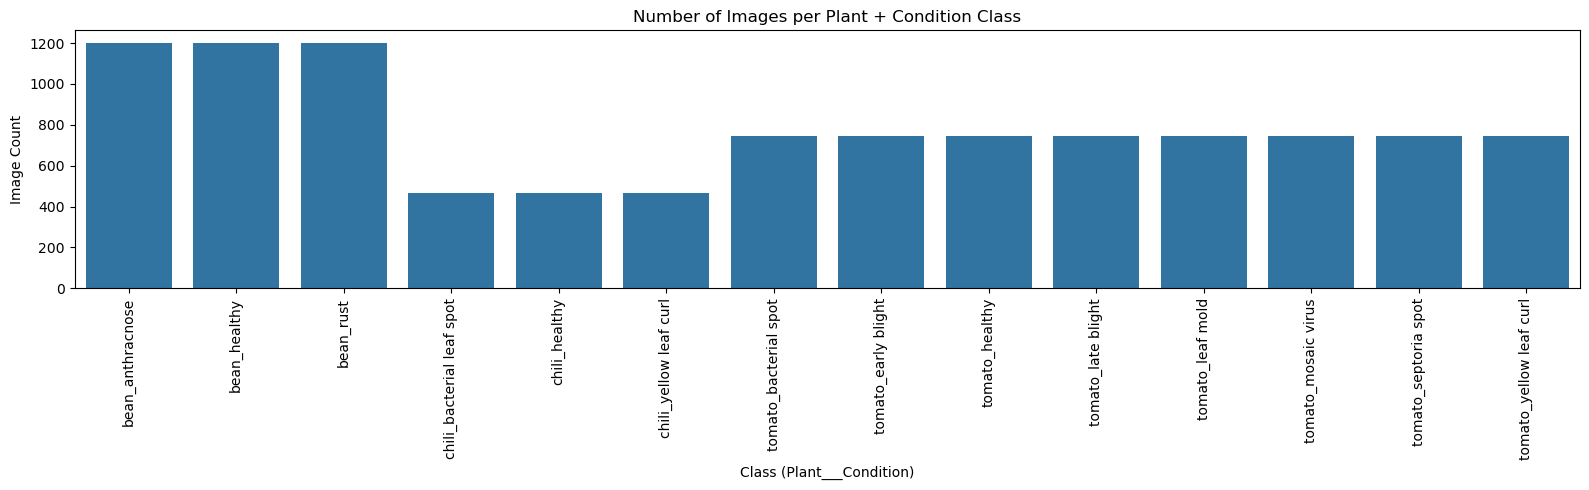

In [6]:
# Count number of images per class (combined_label)
class_counts = df_original["combined_label"].value_counts().sort_index()

# Visualize
plt.figure(figsize=(16, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=90)
plt.title("Number of Images per Plant + Condition Class")
plt.ylabel("Image Count")
plt.xlabel("Class (Plant___Condition)")
plt.tight_layout()
plt.show()


In [7]:
def show_samples_from_df(df, class_names, per_class=4, base_path=original_folder):
    fig, axes = plt.subplots(len(class_names), per_class, figsize=(per_class * 2.5, len(class_names) * 2.5))

    for i, class_name in enumerate(class_names):
        # Filter DataFrame for this class
        samples = df[df["combined_label"] == class_name].sample(n=per_class, replace=True, random_state=42)

        for j in range(per_class):
            ax = axes[i, j] if len(class_names) > 1 else axes[j]
            if j < len(samples):
                # Convert relative path back to full path
                img_path = base_path / Path(samples.iloc[j]["image_path"])
                try:
                    img = Image.open(img_path)
                    ax.imshow(img)
                except Exception as e:
                    ax.set_facecolor("lightgray")
                    ax.text(0.5, 0.5, f"Error\n{e}", ha='center', va='center', fontsize=6)
            else:
                ax.set_facecolor("lightgray")
                ax.text(0.5, 0.5, "No image", ha='center', va='center', fontsize=8)

            ax.axis('off')
            if j == 0:
                ax.set_title(class_name, fontsize=9, loc='left')

    plt.tight_layout()
    plt.show()


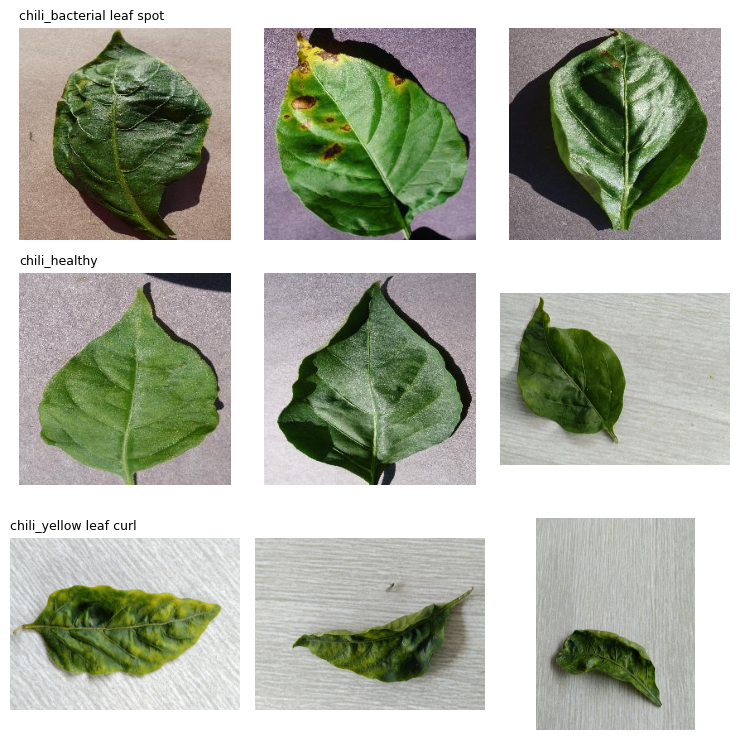

In [8]:
# Show samples from 3 selected classes
some_classes = df_original["combined_label"].unique()[:3]
show_samples_from_df(df_original, class_names=some_classes, per_class=3)


              Width        Height
count  10955.000000  10955.000000
mean     666.631127    661.608215
std      816.845531    724.105139
min      256.000000    256.000000
25%      256.000000    256.000000
50%      256.000000    256.000000
75%      750.000000    800.000000
max     4160.000000   4160.000000


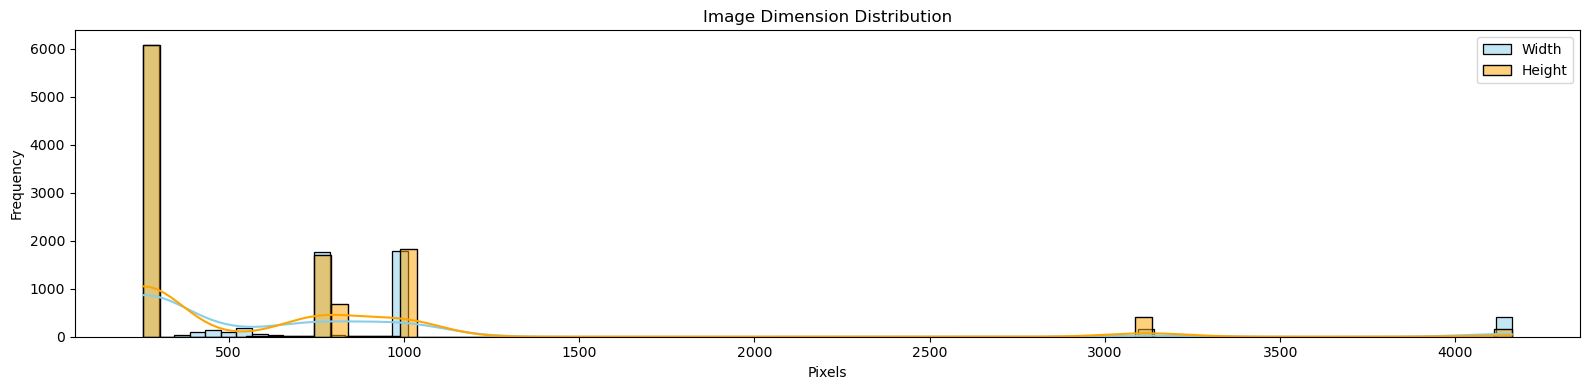

In [9]:
# Checking distribution of image dimensions
image_shapes = []

for i, row in df_original.iterrows():
    img_path = original_folder / Path(row["image_path"])
    try:
        with Image.open(img_path) as img:
            image_shapes.append(img.size)
    except Exception as e:
        print(f"⚠️ Error opening {img_path.name}: {e}")

# Create DataFrame of dimensions
shapes_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
print(shapes_df.describe())

# Plot histogram
plt.figure(figsize=(16, 4))
sns.histplot(shapes_df["Width"], color="skyblue", label="Width", kde=True)
sns.histplot(shapes_df["Height"], color="orange", label="Height", kde=True)
plt.title("Image Dimension Distribution")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


# Greyscaling and dataload


In [10]:
# Convert images to grayscale
def convert_folder_to_grayscale(base_folder: Path, gray_folder: Path):
    valid_exts = {".jpg", ".jpeg", ".png"}
    for plant_folder in base_folder.iterdir():
        if plant_folder.is_dir():
            plant = plant_folder.name.lower().strip()

            for condition_folder in plant_folder.iterdir():
                if condition_folder.is_dir():
                    condition = condition_folder.name.lower().strip()
                    target_folder = gray_folder / plant / condition
                    target_folder.mkdir(parents=True, exist_ok=True)

                    for img_path in condition_folder.glob("*"):
                        ext = Path(str(img_path).lower()).suffix
                        if ext in valid_exts:
                            try:
                                img = Image.open(img_path).convert("L")
                                new_filename = target_folder / img_path.name
                                img.save(new_filename)
                            except Exception as e:
                                print(f"Skipping {img_path.name}: {e}")

In [11]:
# Input and output root folders
input_folder = Path("Plant_Diseases")
grayscale_folder = Path("Plants_gray_clean")
grayscale_folder.mkdir(exist_ok=True)

# Converting af loading grayscaled images
convert_folder_to_grayscale(input_folder, grayscale_folder)
df_grayscale = load_metadata(grayscale_folder)

print(df_grayscale.head())
print(f"\nTotal grayscale images: {len(df_grayscale)}")

                                          image_path  plant condition  \
0  /work/Exam ML 2025/Plants_gray_clean/chili/hea...  chili   healthy   
1  /work/Exam ML 2025/Plants_gray_clean/chili/hea...  chili   healthy   
2  /work/Exam ML 2025/Plants_gray_clean/chili/hea...  chili   healthy   
3  /work/Exam ML 2025/Plants_gray_clean/chili/hea...  chili   healthy   
4  /work/Exam ML 2025/Plants_gray_clean/chili/hea...  chili   healthy   

  combined_label  
0  chili_healthy  
1  chili_healthy  
2  chili_healthy  
3  chili_healthy  
4  chili_healthy  

Total grayscale images: 10955


In [12]:
# Setup
np.random.seed(42)
gray_base_dir = Path("Plants_gray_clean")
df_grayscale['full_path'] = df_grayscale['image_path'].apply(lambda p: gray_base_dir / p)

# Function to load grayscale images
def load_grayscale_images(paths, target_size=(128, 128)):
    images = []
    for p in paths:
        try:
            img = load_img(str(p), color_mode='grayscale', target_size=target_size)
            img_array = img_to_array(img) 
            images.append(img_array)
        except Exception as e:
            print(f"Skipping {p.name}: {e}")
    return np.array(images)

# Load image data and labels
x = load_grayscale_images(df_grayscale['full_path'])
y = df_grayscale['combined_label'].values

print(f"Loaded grayscale images: {x.shape}")
print(f"Amount of labels: {y.shape}")

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Training samples: {x_train.shape}")
print(f"Testing samples: {x_test.shape}")


Loaded grayscale images: (10955, 128, 128, 1)
Amount of labels: (10955,)
Training samples: (8764, 128, 128, 1)
Testing samples: (2191, 128, 128, 1)


In [13]:
# Creating train/test folders in directory for faster load
input_base_dir = Path("Plant_Diseases")
output_base_dir = Path("Plants_gray_clean/split")

# Clear existing output directory
if output_base_dir.exists():
    shutil.rmtree(output_base_dir)
output_base_dir.mkdir(parents=True, exist_ok=True)

# Split the data 
train_df, test_df = train_test_split(
    df_grayscale,
    test_size=0.20,
    stratify=df_grayscale["combined_label"],
    random_state=42
)

# Print counts 
print(f"Total images: {len(df_grayscale)}")
print(f"Train images: {len(train_df)}")
print(f"Test images:  {len(test_df)}")
splits = {
    "train": train_df,
    "test": test_df
}

# Copy files to new folders 
for split_name, split_df in splits.items():
    for _, row in split_df.iterrows():
        src = input_base_dir / Path(row["image_path"])
        dest = output_base_dir / split_name / row["plant"] / row["condition"]
        dest.mkdir(parents=True, exist_ok=True)

        try:
            shutil.copy(src, dest / src.name)
        except Exception as e:
            print(f"Failed to copy {src}: {e}")

print("80/20 split complete. Folders created in:", output_base_dir)

Total images: 10955
Train images: 8764
Test images:  2191
80/20 split complete. Folders created in: Plants_gray_clean/split


# Loading train and test data (Run from here if you already have train/test split dataset)

In [4]:
# Loading train/test into dataframes
train_df = load_metadata(Path("Plants_gray_clean/split/train"))
test_df = load_metadata(Path("Plants_gray_clean/split/test"))

print(f"train_df: {len(train_df)} images")
print(f"test_df:  {len(test_df)} images")
print(train_df.head())

train_df: 8764 images
test_df:  2191 images
                                          image_path plant    condition  \
0  /Users/khoaduynguyen/Desktop/ML Exam/Plants_gr...  bean  anthracnose   
1  /Users/khoaduynguyen/Desktop/ML Exam/Plants_gr...  bean  anthracnose   
2  /Users/khoaduynguyen/Desktop/ML Exam/Plants_gr...  bean  anthracnose   
3  /Users/khoaduynguyen/Desktop/ML Exam/Plants_gr...  bean  anthracnose   
4  /Users/khoaduynguyen/Desktop/ML Exam/Plants_gr...  bean  anthracnose   

     combined_label  
0  bean_anthracnose  
1  bean_anthracnose  
2  bean_anthracnose  
3  bean_anthracnose  
4  bean_anthracnose  


In [5]:
img_size = (128, 128)
batch_size = 32


# Unshuffled testing/val generator for Logistic + SVM
train_gen_lrsvm = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='combined_label',
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False  
)

# Test generator for Logistic + SVM
test_gen_lrsvm = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='combined_label',
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False  
)



# Defining data generator to augment data for CNN
train_datagen_cnn = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Training generator with shuffle = true for CNN
train_gen_cnn = train_datagen_cnn.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='combined_label',
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True  
)
test_gen_cnn = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='combined_label',
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False  
)

Found 8764 validated image filenames belonging to 14 classes.
Found 2191 validated image filenames belonging to 14 classes.
Found 8764 validated image filenames belonging to 14 classes.
Found 2191 validated image filenames belonging to 14 classes.


In [6]:
# Load into x,y for LR + SVM 
x_train, y_train = next(train_gen_lrsvm)
for _ in range(1, len(train_gen_lrsvm)):
    x, y = next(train_gen_lrsvm)
    x_train = np.concatenate((x_train, x))
    y_train = np.concatenate((y_train, y))

x_test, y_test = next(test_gen_lrsvm)
for _ in range(1, len(test_gen_lrsvm)):
    x, y = next(test_gen_lrsvm)
    x_test = np.concatenate((x_test, x))
    y_test = np.concatenate((y_test, y))

# Printing to see results
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (8764, 128, 128, 1)
y_train shape: (8764, 14)
x_test shape: (2191, 128, 128, 1)
y_test shape: (2191, 14)


In [7]:
# Flatten and scale
def flatten_and_scale(x_train, x_test):
    x_train = x_train
    x_test = x_test
    x_train_flat = x_train.reshape(len(x_train), -1)
    x_test_flat = x_test.reshape(len(x_test), -1)
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_flat)
    x_test_scaled = scaler.transform(x_test_flat)
    return x_train_scaled, x_test_scaled


In [8]:
# Apply it
x_train_scaled, x_test_scaled = flatten_and_scale(x_train, x_test)

print("x_train_flat shape:", x_train_scaled.shape)
print("x_test_flat shape:", x_test_scaled.shape)

x_train_flat shape: (8764, 16384)
x_test_flat shape: (2191, 16384)


In [9]:
# Convert one-hot → integer labels  (shape (n_samples, n_classes) ➜ (n_samples,))
y_train_vec = y_train.argmax(axis=1).astype("int64")
y_test_vec  = y_test.argmax(axis=1).astype("int64")

print("y_train_vec shape:", y_train_vec.shape)
print("y_test_vec  shape:", y_test_vec.shape)


y_train_vec shape: (8764,)
y_test_vec  shape: (2191,)


# Evaluation function

In [10]:
# For logistic and svm
def evaluate_train_test_classifier(
    model,
    x_train, y_train,
    x_test, y_test,
    class_names=None):
    # Predict
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    # Train metrics
    print("\nTrain Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Train Classification Report:\n", classification_report(y_train, y_pred_train, target_names=class_names))

    # Test metrics
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred_test))
    print("Test Classification Report:\n", classification_report(y_test, y_pred_test, target_names=class_names))

    # Confusion matrix - Train
    cm_train = confusion_matrix(y_train, y_pred_train)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix - Train Set")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Confusion matrix - Test
    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix - Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# Logistic Regression


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Train Accuracy: 1.0
Train Classification Report:
                            precision    recall  f1-score   support

         bean_anthracnose       1.00      1.00      1.00       962
             bean_healthy       1.00      1.00      1.00       960
                bean_rust       1.00      1.00      1.00       958
chili_bacterial leaf spot       1.00      1.00      1.00       372
            chili_healthy       1.00      1.00      1.00       372
   chili_yellow leaf curl       1.00      1.00      1.00       372
    tomato_bacterial spot       1.00      1.00      1.00       596
      tomato_early blight       1.00      1.00      1.00       596
           tomato_healthy       1.00      1.00      1.00       596
       tomato_late blight       1.00      1.00      1.00       596
         tomato_leaf mold       1.00      1.00      1.00       596
      tomato_mosaic virus       1.00      1.00      1.00       596
     tomato_septoria spot       1.00      1.00      1.00       596
  tomato_y

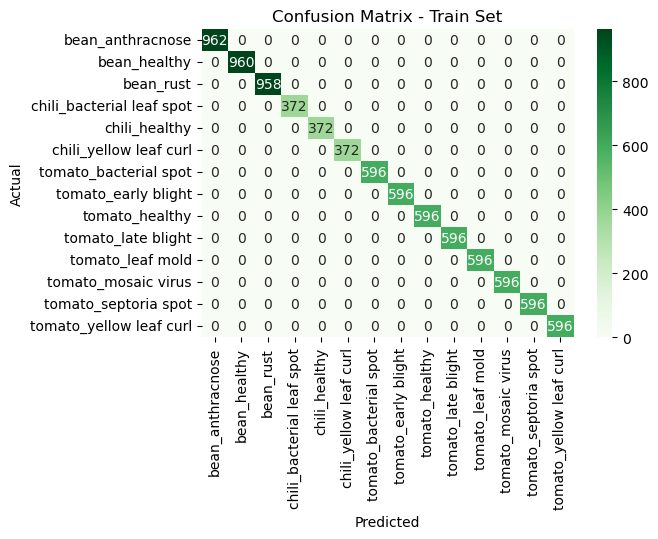

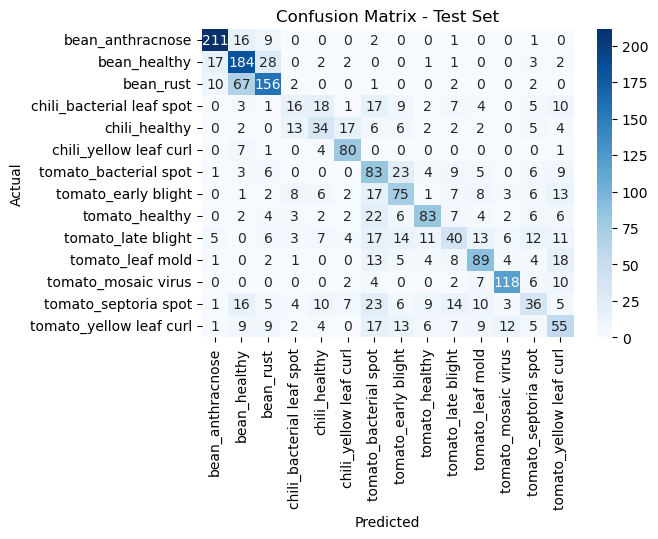


 LR Base Training Runtime: 3938.58 seconds


In [41]:
# Base model for logistic regression
lr_base = LogisticRegression (solver="saga", max_iter=500, random_state=42)

start_time = time.time()

lr_base.fit(x_train_scaled, y_train_vec)
evaluate_train_test_classifier(
    model=lr_base,
    x_train=x_train_scaled, y_train=y_train_vec,
    x_test=x_test_scaled, y_test=y_test_vec,
    class_names= list(train_gen_lrsvm.class_indices.keys()) 
)

end_time = time.time()
runtime_seconds = end_time - start_time
print(f"\n LR Base Training Runtime: {runtime_seconds:.2f} seconds")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Train Accuracy: 0.9799178457325423
Train Classification Report:
                            precision    recall  f1-score   support

         bean_anthracnose       0.99      1.00      1.00       962
             bean_healthy       0.97      0.99      0.98       960
                bean_rust       0.98      0.98      0.98       958
chili_bacterial leaf spot       1.00      0.99      1.00       372
            chili_healthy       1.00      1.00      1.00       372
   chili_yellow leaf curl       1.00      1.00      1.00       372
    tomato_bacterial spot       0.96      0.93      0.94       596
      tomato_early blight       0.98      0.98      0.98       596
           tomato_healthy       0.97      1.00      0.98       596
       tomato_late blight       0.97      0.97      0.97       596
         tomato_leaf mold       0.98      0.98      0.98       596
      tomato_mosaic virus       0.99      1.00      0.99       596
     tomato_septoria spot       0.98      0.93      0.96      

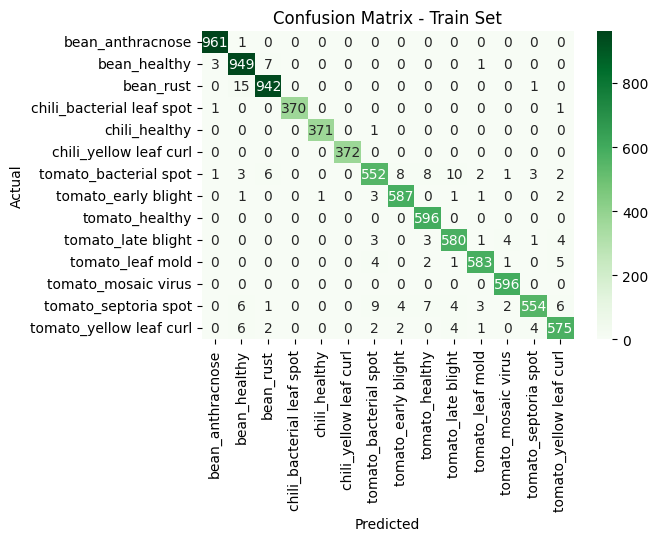

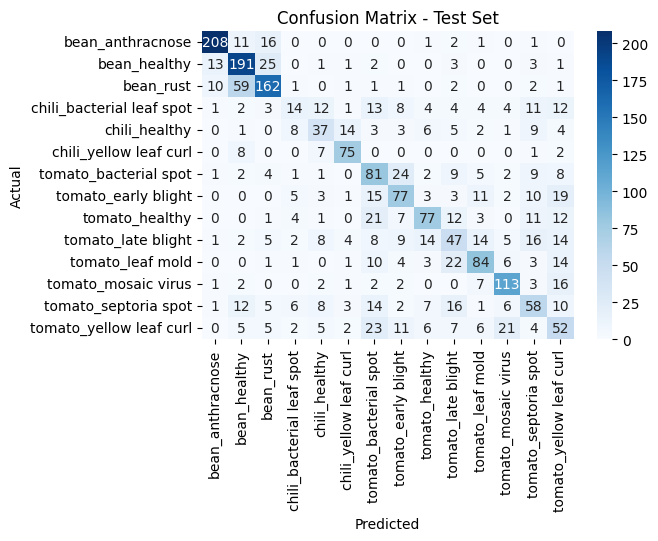


 LR Tuned Training Runtime: 156.71 seconds


In [11]:
# Tuned model for logistic regression
lr_tuned = Pipeline([
    ("pca",   PCA(n_components=0.95, svd_solver="full")),  
    ("logreg", LogisticRegression(
        solver = "lbfgs",
        max_iter=500,
        n_jobs=-1,
        penalty ='l2',
        C=0.01,
        random_state=42))
])
start_time = time.time()

lr_tuned.fit(x_train_scaled, y_train_vec)
evaluate_train_test_classifier(
    model=lr_tuned,
    x_train=x_train_scaled, y_train=y_train_vec,
    x_test=x_test_scaled, y_test=y_test_vec,
    class_names= list(train_gen_lrsvm.class_indices.keys()) 
)

end_time = time.time()

runtime_seconds = end_time - start_time
print(f"\n LR Tuned Training Runtime: {runtime_seconds:.2f} seconds")

# SVM

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Train Accuracy: 0.998630762209037
Train Classification Report:
                            precision    recall  f1-score   support

         bean_anthracnose       1.00      1.00      1.00       962
             bean_healthy       1.00      1.00      1.00       960
                bean_rust       1.00      1.00      1.00       958
chili_bacterial leaf spot       1.00      1.00      1.00       372
            chili_healthy       0.99      1.00      1.00       372
   chili_yellow leaf curl       0.99      1.00      1.00       372
    tomato_bacterial spot       1.00      1.00      1.00       596
      tomato_early blight       1.00      1.00      1.00       596
           tomato_healthy       1.00      1.00      1.00       596
       tomato_late blight       1.00      0.98      0.99       596
         tomato_leaf mold       1.00      1.00      1.00       596
      tomato_mosaic virus       1.00      1.00      1.00       596
     tomato_septoria spot       1.00      1.00      1.00       

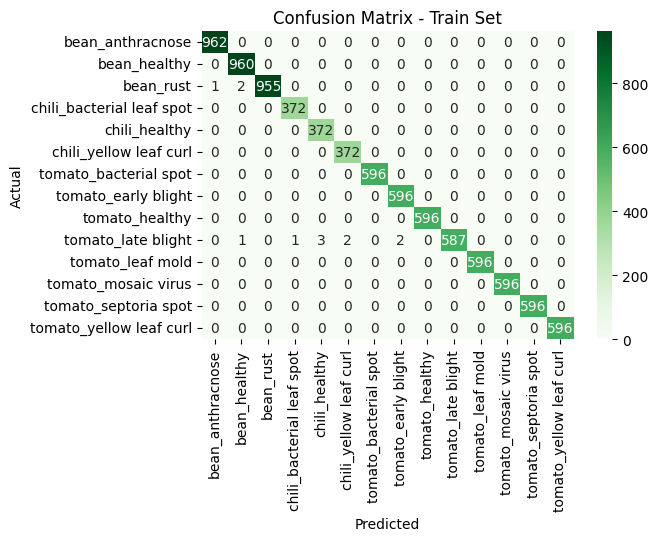

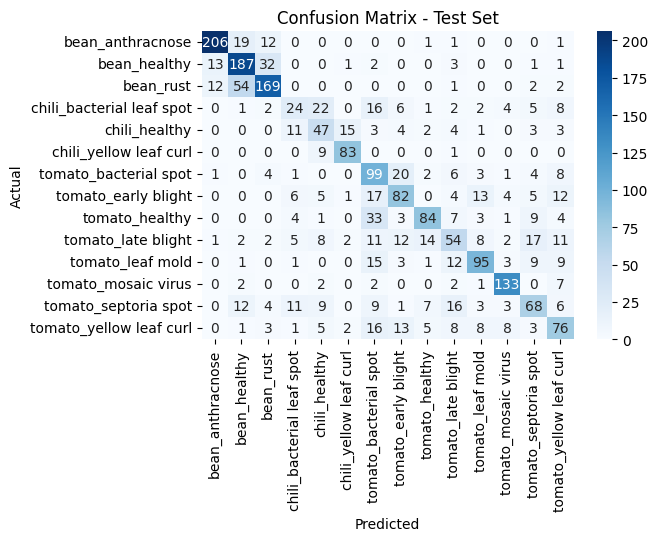


 SVM Training Runtime: 468.46 seconds


In [12]:
#Base model
svm_base = SVC(kernel='linear', max_iter=1000)
# Training the model
start_time = time.time()

svm_base.fit(x_train_scaled, y_train_vec)

evaluate_train_test_classifier(
    model=svm_base,
    x_train=x_train_scaled, y_train=y_train_vec,
    x_test=x_test_scaled, y_test=y_test_vec,
    class_names= list(train_gen_lrsvm.class_indices.keys()) 
)

end_time = time.time()
runtime_seconds = end_time - start_time
print(f"\n SVM Training Runtime: {runtime_seconds:.2f} seconds")



Train Accuracy: 0.9948653582838887
Train Classification Report:
                            precision    recall  f1-score   support

         bean_anthracnose       1.00      1.00      1.00       962
             bean_healthy       0.97      1.00      0.98       960
                bean_rust       1.00      0.97      0.98       958
chili_bacterial leaf spot       1.00      1.00      1.00       372
            chili_healthy       1.00      1.00      1.00       372
   chili_yellow leaf curl       1.00      1.00      1.00       372
    tomato_bacterial spot       1.00      1.00      1.00       596
      tomato_early blight       1.00      1.00      1.00       596
           tomato_healthy       0.99      1.00      1.00       596
       tomato_late blight       1.00      0.99      0.99       596
         tomato_leaf mold       1.00      1.00      1.00       596
      tomato_mosaic virus       0.99      1.00      0.99       596
     tomato_septoria spot       1.00      0.98      0.99      

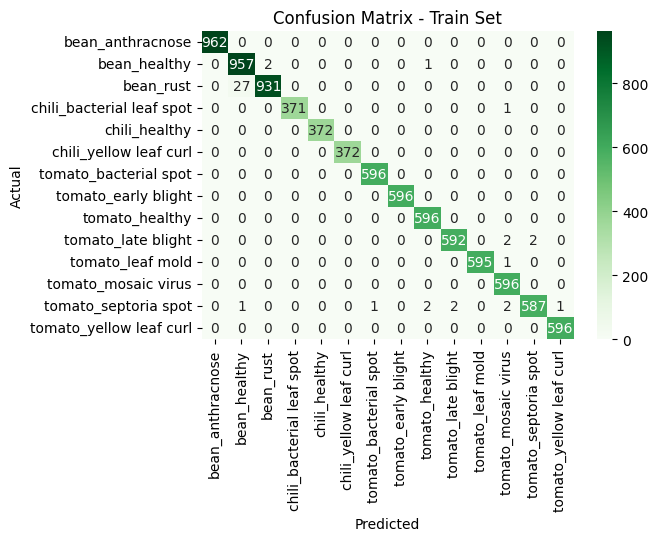

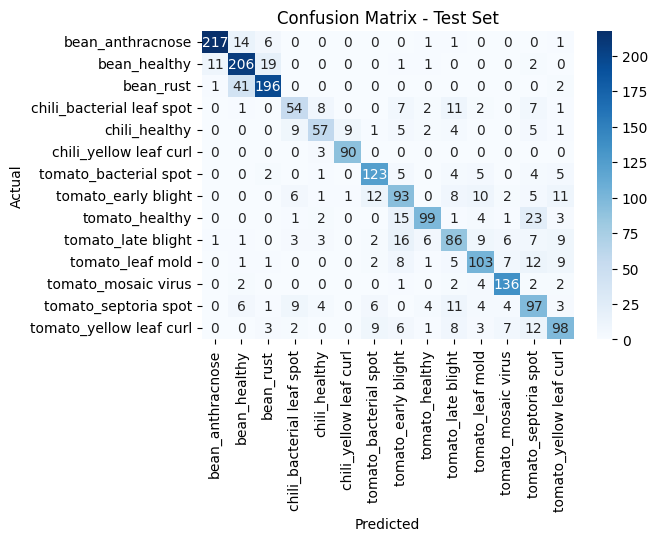


 SVM Training Runtime: 256.98 seconds


In [13]:
# Optimized model
svm_tuned = Pipeline([
    ('pca', PCA(n_components=0.95, svd_solver='auto', random_state=42)),
    ('svm', SVC(
        gamma=0.0001,
        C=5,
        kernel='rbf',      
        random_state=42
    ))
])

start_time = time.time()

svm_tuned.fit(x_train_scaled, y_train_vec)
evaluate_train_test_classifier(
    model=svm_tuned,
    x_train=x_train_scaled, y_train=y_train_vec,
    x_test=x_test_scaled, y_test=y_test_vec,
    class_names= list(train_gen_lrsvm.class_indices.keys()) 
)

end_time = time.time()
runtime_seconds = end_time - start_time
print(f"\n SVM Training Runtime: {runtime_seconds:.2f} seconds")

# CNN

In [33]:
# Train/val curve for CNN
def plot_history_curves(history, title_prefix=''):

    hist = history.history
    plt.figure(figsize=(14, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(hist['loss'], label='Train Loss', marker='o')
    plt.plot(hist.get('val_loss', []), label='Val Loss', marker='o')
    plt.title(f'{title_prefix} Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(hist['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(hist.get('val_accuracy', []), label='Val Accuracy', marker='o')
    plt.title(f'{title_prefix} Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [39]:
def evaluate_cnn_model(model, history, val_gen, class_names=None):
    # Print final and best train/val accuracy from history
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = np.argmax(history.history['val_accuracy']) + 1

    print(f"\nFinal Train Accuracy: {train_acc:.4f}")
    print(f"Final Validation Accuracy: {val_acc:.4f}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")

    # Predict on validation/test generator
    y_true = []
    y_pred = []
    for batch_x, batch_y in val_gen:
        batch_preds = model.predict(batch_x)
        y_true.extend(np.argmax(batch_y, axis=1))
        y_pred.extend(np.argmax(batch_preds, axis=1))
        if len(y_true) >= val_gen.samples:
            break
    y_true = np.array(y_true)[:val_gen.samples]
    y_pred = np.array(y_pred)[:val_gen.samples]

    # Classification report
    print("\nClassification Report:")
    if class_names is None:
        class_names = [str(i) for i in range(len(np.unique(y_true)))]
    print(classification_report(y_true, y_pred, target_names=list(class_names)))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

In [34]:
# Parameters
img_height, img_width = 128, 128
batch_size = 32
epochs = 20
# Class info
class_names = list(train_gen_cnn.class_indices.keys())
num_classes = len(class_names)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [35]:
# Base CNN
cnn_base= Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Flatten(),                         
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile
cnn_base.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Training
start_time = time.time()


history_base = cnn_base.fit(
    train_gen_cnn,
    validation_data=test_gen_cnn,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)

end_time = time.time()
runtime_seconds = end_time - start_time
print(f"\n CNN Training Runtime: {runtime_seconds:.2f} seconds")


/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 68s 243ms/step - accuracy: 0.2429 - loss: 2.1607 - val_accuracy: 0.4934 - val_loss: 1.3981 - learning_rate: 0.0010
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.5495 - loss: 1.2356 - val_accuracy: 0.5879 - val_loss: 1.0879 - learning_rate: 0.0010
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 60s 220ms/step - accuracy: 0.6079 - loss: 1.0671 - val_accuracy: 0.6166 - val_loss: 1.1603 - learning_rate: 0.0010
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.6567 - loss: 0.9369 - val_accuracy: 0.6490 - val_loss: 1.0512 - learning_rate: 0.0010
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.7080 - loss: 0.8004 - val_accuracy: 0.7111 - val_loss: 0.7672 - learning_rate: 0.0010
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.7612 - loss: 0.6827 - val_accuracy: 0.7193 - val_loss: 0.8117 - learning_rate: 0.0010
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 58s 211ms/step - accuracy: 0.7


Final Train Accuracy: 0.8835
Final Validation Accuracy: 0.8257
Best Validation Accuracy: 0.8462 (Epoch 11)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━

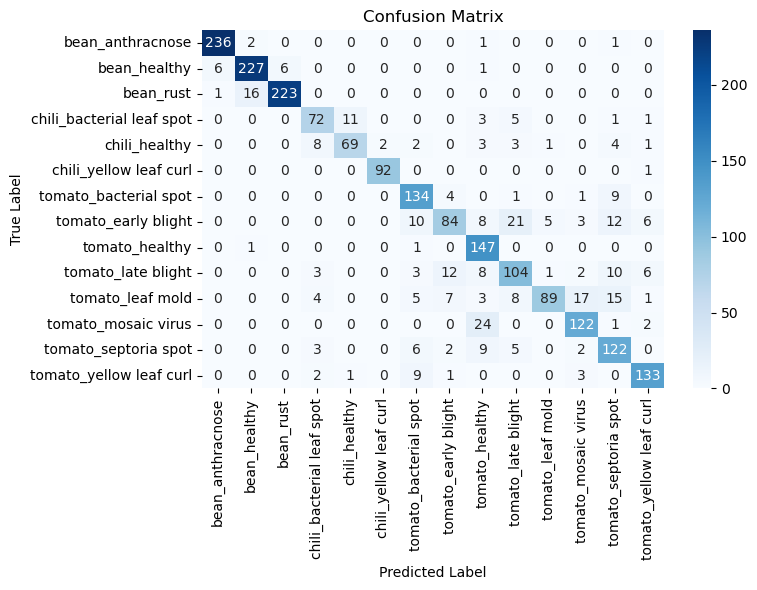

In [42]:
evaluate_cnn_model(cnn_base, history_base, test_gen_cnn, class_names=class_names)


In [38]:
# Tuned CNN
cnn_tuned= Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Flatten(),                         
    Dense(128, activation='relu'),
    Dropout(0.22),
    Dense(num_classes, activation='softmax')
])

# Compile
cnn_tuned.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Training
start_time = time.time()


history_tuned = cnn_tuned.fit(
    train_gen_cnn,
    validation_data=test_gen_cnn,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)

end_time = time.time()
runtime_seconds = end_time - start_time
print(f"\n CNN Training Runtime: {runtime_seconds:.2f} seconds")

/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 63s 226ms/step - accuracy: 0.2087 - loss: 2.2496 - val_accuracy: 0.4979 - val_loss: 1.3989 - learning_rate: 0.0010
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 61s 223ms/step - accuracy: 0.4486 - loss: 1.5407 - val_accuracy: 0.6157 - val_loss: 1.0360 - learning_rate: 0.0010
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 61s 223ms/step - accuracy: 0.5522 - loss: 1.2151 - val_accuracy: 0.6394 - val_loss: 0.9195 - learning_rate: 0.0010
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 61s 223ms/step - accuracy: 0.5999 - loss: 1.0657 - val_accuracy: 0.6700 - val_loss: 0.8469 - learning_rate: 0.0010
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 60s 220ms/step - accuracy: 0.6445 - loss: 0.9802 - val_accuracy: 0.7166 - val_loss: 0.7458 - learning_rate: 0.0010
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 61s 221ms/step - accuracy: 0.6615 - loss: 0.9108 - val_accuracy: 0.6997 - val_loss: 0.8716 - learning_rate: 0.0010
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.69


Final Train Accuracy: 0.8253
Final Validation Accuracy: 0.8288
Best Validation Accuracy: 0.8421 (Epoch 13)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━

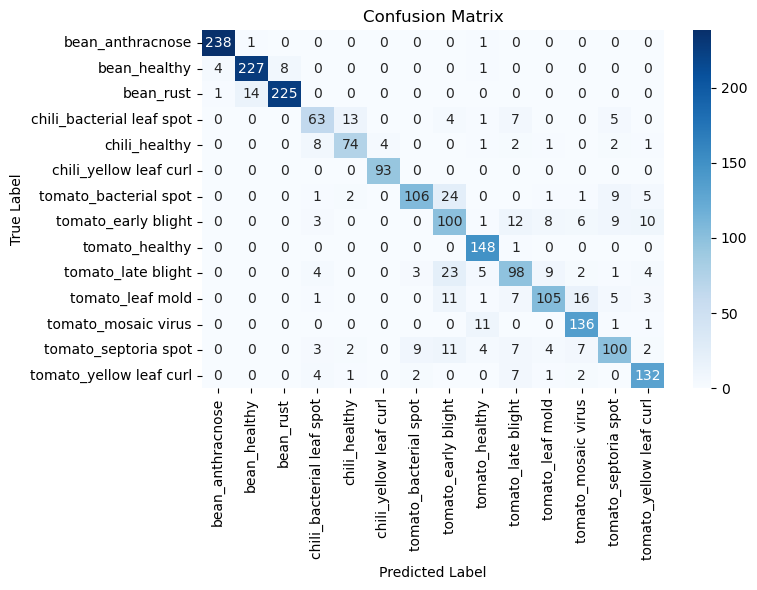

In [40]:
evaluate_cnn_model(cnn_tuned, history_tuned, test_gen_cnn, class_names=class_names)

# Test/tuning hyperparameters for models (Uncomment the code blocks to run the test)

## CNN

In [ ]:
# # Parameters
# img_height, img_width = 128, 128
# batch_size = 32
# epochs = 20
# # Class info
# class_names = list(train_gen_cnn.class_indices.keys())
# num_classes = len(class_names)

# # Callbacks
# early_stop = EarlyStopping(
#     monitor='val_accuracy',
#     patience=4,
#     restore_best_weights=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.5,
#     patience=2,
#     verbose=1,
#     min_lr=1e-6
# )

In [ ]:
# # Build model with dropout as only tunable parameter
# def build_model_drop(hp):
#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
#         MaxPooling2D(2, 2),

#         Conv2D(64, (3, 3), activation='relu', padding='same'),
#         MaxPooling2D(2, 2),

#         Conv2D(128, (3, 3), activation='relu', padding='same'),
#         MaxPooling2D(2, 2),

#         Conv2D(128, (3, 3), activation='relu', padding='same'),
#         MaxPooling2D(2, 2),

#         Flatten(),
#         Dense(128, activation='relu'),  
#         Dropout(hp.Float('dropout', 0.15, 0.3, step=0.1)),
#         Dense(num_classes, activation='softmax')
#     ])

#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

# # Tuner setup
# tuner = RandomSearch(
#     build_model_drop,
#     objective='val_accuracy',
#     max_trials=10,
#     executions_per_trial=1,
#     directory='dropout_logs_final',
#     project_name='dropout_4layers'
# )

# # Start tuning
# tuner.search(
#     train_gen_cnn,
#     validation_data=test_gen_cnn,
#     callbacks=[early_stop, reduce_lr],
#     verbose=1,
#     epochs=20  
# )

# # Best model + hyperparameters
# best_model = tuner.get_best_models()[0]
# best_hp = tuner.get_best_hyperparameters()[0]

# print("\nBest Dropout Rate Found:", best_hp.get('dropout'))

In [ ]:
# # Build model with L2 as the only tunable parameter
# def build_model_l2(hp):
#     reg = l2(hp.Choice('l2', [1e-4, 1e-3, 1e-2]))

#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg, input_shape=(128, 128, 1)),
#         MaxPooling2D(2, 2),

#         Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
#         MaxPooling2D(2, 2),

#         Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
#         MaxPooling2D(2, 2),

#         Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
#         MaxPooling2D(2, 2),

#         Flatten(),
#         Dense(128, activation='relu', kernel_regularizer=reg),
#         Dense(num_classes, activation='softmax')
#     ])

#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

# #  Tuner setup
# tuner = RandomSearch(
#     build_model_l2,
#     objective='val_accuracy',
#     max_trials=10,
#     executions_per_trial=1,
#     directory='l2_logs_final',
#     project_name='l2_4layers'
# )

# # Start tuning
# tuner.search(
#     train_gen_cnn,
#     validation_data=test_gen_cnn,
#     callbacks=[early_stop, reduce_lr],
#     verbose=1,
#     epochs=20  
# )

# # Best model + hyperparameters
# best_model = tuner.get_best_models()[0]
# best_hp = tuner.get_best_hyperparameters()[0]

# print("L2:", best_hp.get('l2'))

## Logistic Regression

In [ ]:
# # Logistic Regression model
# pipe = Pipeline([
#     ('pca',   PCA(n_components=0.95, svd_solver='auto', random_state=42)),
#     ('clf',   LogisticRegression(
#                  multi_class='multinomial',
#                  solver='lbfgs',
#                  max_iter=500,
#                  n_jobs=-1))
# ])
# # Hyperparameter distribution for RandomizedSearchCV
# param_dist = {
#     'clf__C': [0.001, 0.01, 1, 10],
#     'clf__solver': ['saga', 'lbfgs'],
#     'clf__penalty': ['l2', 'l1'],
#     'clf__class_weight': [None, 'balanced'],
# }

# # RandomizedSearchCV for hyperparameter tuning with reduced parallel jobs and iterations
# random_search = RandomizedSearchCV(
#     pipe,
#     param_distributions=param_dist,
#     n_iter=8,  
#     cv=3,  
#     random_state=42,
#     n_jobs=-1,
#     verbose=1,
# )

# # Track time and fit the model
# start_time = time.time()

# try:
#     random_search.fit(x_train_scaled, y_train_vec)
# except Exception as e:
#     print(f"Error during RandomizedSearchCV fitting: {e}")

# end_time = time.time()
# runtime_log = end_time - start_time
# print(f"\n RandomizedSearchCV Runtime: {runtime_log:.2f} seconds")
# print("Best Hyperparameters found: ", random_search.best_params_)


## SVM

In [ ]:
# #previous hyperparameters random searches 
# #'C':     [0.1,1, 5,10,15,20, 30, 50],
# #'gamma': [0.0005, 0.0008, 0.001, 0.0001, 0.001, 0.01],
# svm_tuned = Pipeline([
#     ('pca', PCA(n_components=0.95, svd_solver='auto', random_state=42)),
#     ('svm', SVC(
#         gamma=0.001,
#         C=20,
#         kernel='rbf',      
#         random_state=42
#     ))
# ])
# param_distributions = {
#     'pca__n_components': [0.75, 0.85,0.95],
#     'svm__C': [0.1, 1, 5],
#     'svm__gamma': [1e-4, 1e-3]
# }
# random_search = RandomizedSearchCV(
#     svm_tuned,
#     param_distributions=param_distributions,
#     n_iter=8,
#     cv=5,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(x_train_scaled, y_train_vec)

# best_model = random_search.best_estimator_
# print("Best hyperparameters:", random_search.best_params_)

